 # **Energy Consumption Time Series Forecasting**

**Forecast short-term household energy usage using historical time-based patterns.**


 ## **Data Parsing and Resampling**

In [6]:
# Install if needed
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [7]:
#Load the dataset
import pandas as pd

df = pd.read_csv(
    '/content/household_power_consumption.txt',
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values='?',
    low_memory=False
)


In [8]:
df

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
162490,2007-04-08 13:34:00,0.412,0.000,240.67,2.0,0.0,0.0,0.0
162491,2007-04-08 13:35:00,0.442,0.098,240.42,2.2,0.0,0.0,0.0
162492,2007-04-08 13:36:00,0.326,0.118,240.51,1.4,0.0,0.0,0.0
162493,2007-04-08 13:37:00,0.328,0.118,240.43,1.4,0.0,0.0,0.0


In [21]:
#Check top rows
print(df.head())

#  Check data types
print(df.dtypes)

                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [10]:
#Convert Datetime to index
df.set_index('Datetime', inplace=True)

In [11]:
#Convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:
 #Check missing values
print(df.isnull().sum())

Global_active_power       9
Global_reactive_power    10
Voltage                  10
Global_intensity         10
Sub_metering_1           10
Sub_metering_2           10
Sub_metering_3           10
dtype: int64


In [13]:
# Drop missing values
df.dropna(inplace=True)

#  Resample to hourly
df_hourly = df.resample('H').mean()

## **Visualize energy usage trend**

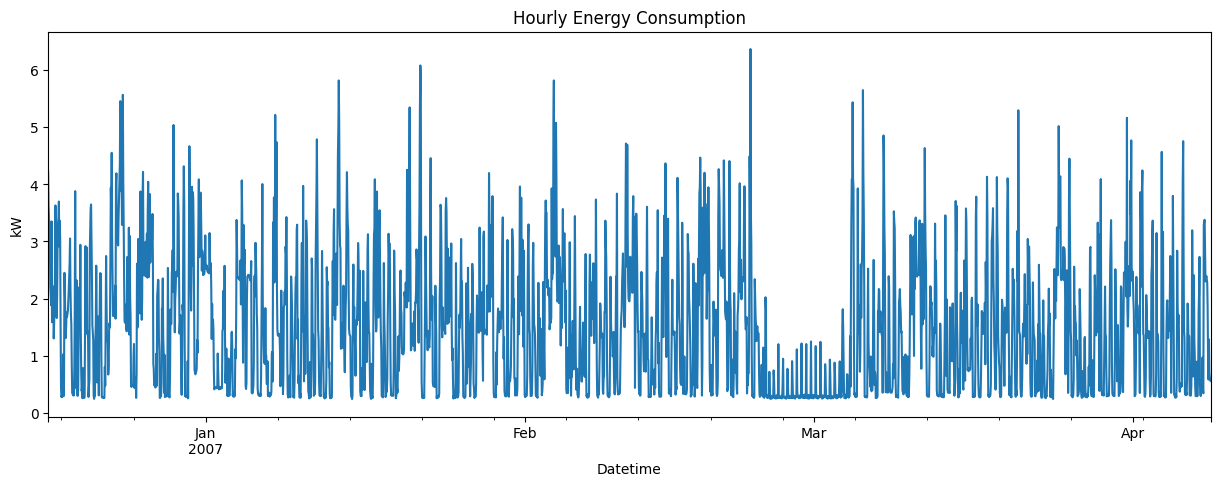

In [15]:
df_hourly['Global_active_power'].plot(figsize=(15,5), title='Hourly Energy Consumption')
plt.ylabel("kW")
plt.show()

In [22]:
df_hourly.index = pd.to_datetime(df_hourly.index)  # ensure index is datetime
df_hourly = df_hourly.loc['2007']  #  correctly filters all rows from year 2007


## **Feature Engineering**

In [24]:
df_hourly = df_hourly.reset_index()

In [25]:
#Create hour and day features
df_hourly['hour'] = df_hourly['Datetime'].dt.hour
df_hourly['day'] = df_hourly['Datetime'].dt.day
df_hourly['weekday'] = df_hourly['Datetime'].dt.weekday
df_hourly['month'] = df_hourly['Datetime'].dt.month


In [26]:
 #Weekend flag
df_hourly['is_weekend'] = df_hourly['weekday'].apply(lambda x: 1 if x >= 5 else 0)


In [27]:
 #Create target column
df_hourly['target'] = df_hourly['Global_active_power'].shift(-1)

In [28]:
#Drop nulls from target shift
df_hourly.dropna(inplace=True)

## **Split Data**

In [30]:
features = ['hour', 'day', 'weekday', 'month', 'is_weekend']
X = df_hourly[features]
y = df_hourly['target']

In [33]:
#Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [34]:
#Print shapes
print(X_train.shape, X_test.shape)


(1872, 5) (469, 5)


In [35]:
#Store actual values for later comparison
actual = y_test.reset_index(drop=True)

In [36]:
#Reset index
X_test = X_test.reset_index(drop=True)

##**XGBoost Model**

In [37]:
 #Train XGBoost
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
 #Predict
xgb_preds = model_xgb.predict(X_test)


In [39]:
#Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

In [40]:
 #Print metrics
print(f'XGBoost MAE: {xgb_mae:.3f}, RMSE: {xgb_rmse:.3f}')


XGBoost MAE: 1.046, RMSE: 1.421


## **Plot prediction**


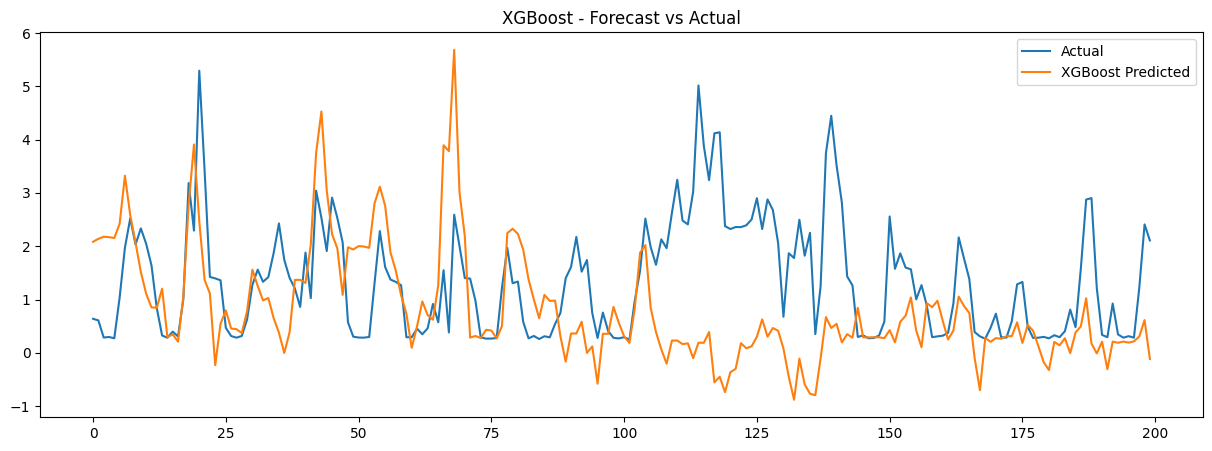

In [41]:

plt.figure(figsize=(15,5))
plt.plot(actual[:200], label='Actual')
plt.plot(xgb_preds[:200], label='XGBoost Predicted')
plt.legend()
plt.title('XGBoost - Forecast vs Actual')
plt.show()

## **ARIMA Model**

In [43]:
 #Use only power column for ARIMA
series = df_hourly['Global_active_power']


In [48]:
#Split series
train_size = int(len(series) * 0.8)
train_arima, test_arima = series[:train_size], series[train_size:]

In [49]:
# Fit ARIMA
model_arima = ARIMA(train_arima, order=(5,1,0))
model_arima_fit = model_arima.fit()


In [51]:
#Forecast
arima_preds = model_arima_fit.forecast(steps=len(test_arima))

In [53]:
#Evaluate
arima_mae = mean_absolute_error(test_arima, arima_preds)
arima_rmse = np.sqrt(mean_squared_error(test_arima, arima_preds))
print(f'ARIMA MAE: {arima_mae:.3f}, RMSE: {arima_rmse:.3f}')#

ARIMA MAE: 0.978, RMSE: 1.150


## **Prophet Model**

In [55]:
 #Prepare dataframe
df_prophet = df_hourly[['Datetime', 'Global_active_power']].rename(columns={
    'Datetime': 'ds',
    'Global_active_power': 'y'
})

In [56]:
 #Train-test split
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]


In [57]:
#Fit Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pyrfeyw/l0z2c6ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pyrfeyw/hppqsa_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79432', 'data', 'file=/tmp/tmp8pyrfeyw/l0z2c6ug.json', 'init=/tmp/tmp8pyrfeyw/hppqsa_3.json', 'output', 'file=/tmp/tmp8pyrfeyw/prophet_model5vnd0ht9/prophet_model-20250721093407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [58]:
#Make future dataframe
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = model_prophet.predict(future)

In [59]:
#Evaluate
prophet_preds = forecast['yhat'].iloc[-len(test_prophet):].values
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_preds)
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_preds))
print(f'Prophet MAE: {prophet_mae:.3f}, RMSE: {prophet_rmse:.3f}')

Prophet MAE: 0.717, RMSE: 0.902


## **Comparison & Plotting**

In [60]:
#Collect all results
results = {
    'Model': ['XGBoost', 'ARIMA', 'Prophet'],
    'MAE': [xgb_mae, arima_mae, prophet_mae],
    'RMSE': [xgb_rmse, arima_rmse, prophet_rmse]
}

In [61]:
#Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)

     Model       MAE      RMSE
0  XGBoost  1.045762  1.421159
1    ARIMA  0.977948  1.149514
2  Prophet  0.717483  0.901928


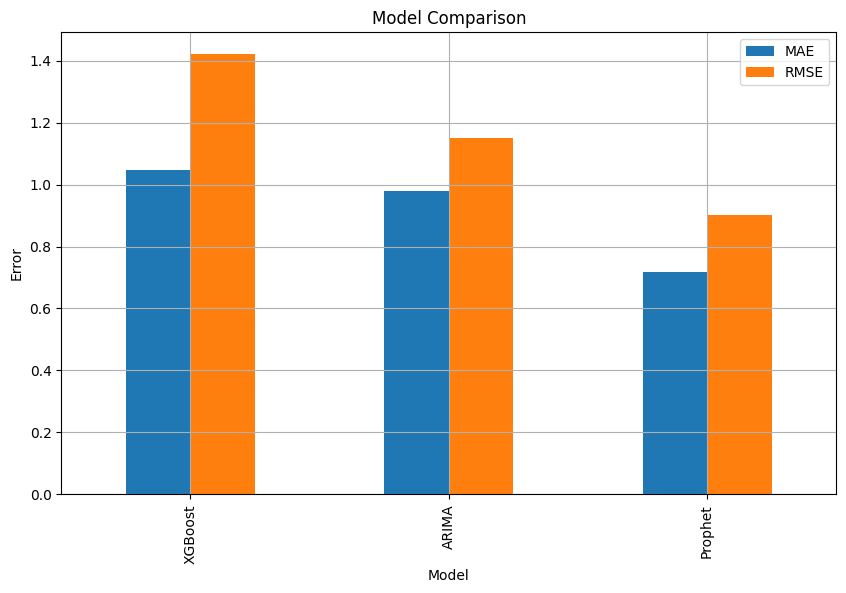

In [62]:
#Bar Plot
df_results.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', figsize=(10,6), title='Model Comparison')
plt.ylabel('Error')
plt.grid(True)
plt.show()


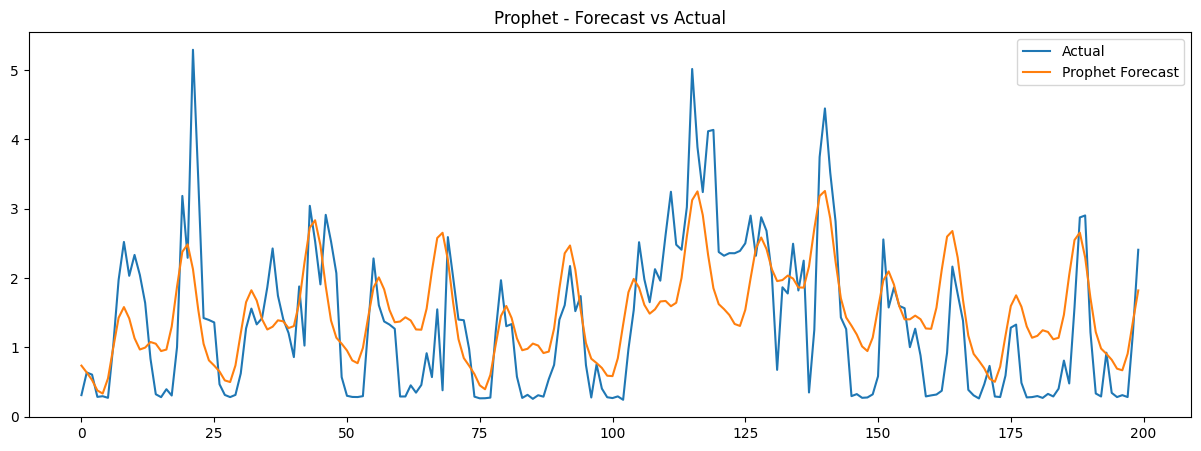

In [63]:
#Visual Comparison (Prophet)
plt.figure(figsize=(15,5))
plt.plot(test_prophet['y'].values[:200], label='Actual')
plt.plot(prophet_preds[:200], label='Prophet Forecast')
plt.legend()
plt.title('Prophet - Forecast vs Actual')
plt.show()

In [65]:
 #Print Best Model
best_model = df_results.loc[df_results['RMSE'].idxmin()]
print(f"\n Best Model is: {best_model['Model']} with RMSE: {best_model['RMSE']:.3f}")


 Best Model is: Prophet with RMSE: 0.902
